# Data Understanding

### a) Specifying the Question

> Performing sentiment analysis on people's views towards six United States airlines.


### b) Defining the Metric for Success

Our project will be cinsidered successful if we can effectively build a Neural network model that can give an accuracy of more than 90%.

### c) Understanding the context 


We analyze seven days of data from Twitter regarding customer sentiment for 6 US airlines: American, Delta, Southwest Airlines, United, US Airways, and Virgin America.Then use Tensor Flow to predict the chance of a tweet to be positive,negative or neutral.

### d) Recording the Experimental Design

The following steps will be followed in conducting this analysis:
1. Defining the Question
2. Reading the Data.
3. Data Exploration.
4. Data Cleaning
5. Data Analysis
6. Models
7. Evaluation of the solution
8. Challenging the solution
9. Conclusion

### e) Data Relevance

This will be discussed after the analysis

# Importing the libraries

In [ ]:
#Import the libraries
import tweepy
import re #regular expression
import pandas as pd
import numpy as np
import seaborn as sns
import string
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

# modelling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

#For cleaning the tweets
import re
import string
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.lancaster import LancasterStemmer

#for metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load the dataset

In [ ]:
#load the dataset
df=pd.read_csv('Tweets.csv')

In [ ]:
#Preview the head
df=df.rename(columns={'airline_sentiment': 'sentiment'})
df.head()

,tweet_id,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
#check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4493 entries, 0 to 4492
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      4493 non-null   int64  
 1   sentiment                     4493 non-null   object 
 2   airline_sentiment_confidence  4493 non-null   float64
 3   negativereason                2906 non-null   object 
 4   negativereason_confidence     3349 non-null   float64
 5   airline                       4493 non-null   object 
 6   airline_sentiment_gold        8 non-null      object 
 7   name                          4493 non-null   object 
 8   negativereason_gold           7 non-null      object 
 9   retweet_count                 4493 non-null   int64  
 10  text                          4493 non-null   object 
 11  tweet_coord                   376 non-null    object 
 12  tweet_created                 4492 non-null   object 
 13  twe

In [ ]:
#check the shape 
print('This Spam dataset has ' + str(df.shape[0]) + ' rows, and ' + str(df.shape[1]) + ' columns')

This Spam dataset has 4493 rows, and 15 columns


# Preprocessing the dataset

In [ ]:
#Remove patterns in input txt
def remove_pattern(input_txt, pattern):
  r =re.findall(pattern,input_txt)
  for word in r:
    input_txt =re.sub(word, "", input_txt)
  return input_txt

In [ ]:
#Remove twitter handles
df['clean_tweet']= np.vectorize(remove_pattern)(df['text'], "@[\w]*")

In [ ]:
df.head()

,tweet_id,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_tweet
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said.
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you've added commercials to the experien...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didn't today... Must mean I need to take an...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"it's really aggressive to blast obnoxious ""en..."
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it's a really big bad thing about it


In [ ]:
#Remove special characters, numbers, punctuations
df['clean_tweet']=df['clean_tweet'].str.replace('[^a-zA-Z#]', " ")
df.head()

,tweet_id,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_tweet
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you ve added commercials to the experien...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didn t today Must mean I need to take an...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),it s really aggressive to blast obnoxious en...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it s a really big bad thing about it


In [ ]:
#remove short words
df['clean_tweet']=df['clean_tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3])) #Removing short words
df.head()

,tweet_id,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_tweet
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus added commercials experience tacky
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),didn today Must mean need take another trip
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really thing about


In [ ]:
#individual words considered as words
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0                                         [What, said]
1        [plus, added, commercials, experience, tacky]
2    [didn, today, Must, mean, need, take, another,...
3    [really, aggressive, blast, obnoxious, enterta...
4                               [really, thing, about]
Name: clean_tweet, dtype: object

In [ ]:
#stem the words 
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

tokenized_tweet= tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
tokenized_tweet.head()

0                                         [what, said]
1                   [plu, ad, commerci, experi, tacki]
2    [didn, today, must, mean, need, take, anoth, t...
3    [realli, aggress, blast, obnoxi, entertain, yo...
4                               [realli, thing, about]
Name: clean_tweet, dtype: object

In [ ]:
#combine words into a single sentence
for i in range(len(tokenized_tweet)):
  tokenized_tweet[i]= " ".join(tokenized_tweet[i])

df['clean_tweet']=tokenized_tweet
df.head()

,tweet_id,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_tweet
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),what said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plu ad commerci experi tacki
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),didn today must mean need take anoth trip
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),realli aggress blast obnoxi entertain your gue...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),realli thing about


# EDA

In [ ]:
#Get the statistical summaries
df.describe(include='all')

,tweet_id,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_tweet
count,4.493000e+03,4493,4493.000000,2906,3349.000000,4493,8,4493,7,4493.000000,4493,376,4492,3126,3014,4493
unique,NaN,3,NaN,10,NaN,3,2,2480,7,NaN,4475,306,4472,1155,63,4388
top,NaN,negative,NaN,Customer Service Issue,NaN,United,negative,throthra,Cancelled Flight,NaN,@united thanks,"[0.0, 0.0]",2015-02-23 06:57:24 -0800,"San Francisco, CA",Eastern Time (US & Canada),thank
freq,NaN,2906,NaN,772,NaN,3822,7,27,1,NaN,6,66,3,58,1031,47
mean,5.691310e+17,NaN,0.897507,NaN,0.620015,NaN,NaN,NaN,NaN,0.100824,NaN,NaN,NaN,NaN,NaN,NaN
std,7.723104e+14,NaN,0.164428,NaN,0.329164,NaN,NaN,NaN,NaN,0.365877,NaN,NaN,NaN,NaN,NaN,NaN
min,5.675915e+17,NaN,0.335000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,5.685039e+17,NaN,0.689400,NaN,0.355600,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.692420e+17,NaN,1.000000,NaN,0.667000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,5.698087e+17,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


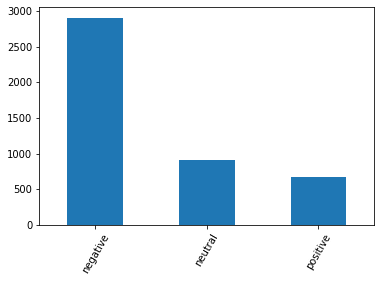

In [ ]:
#Visulize the sentiments
df['sentiment'].value_counts().plot(kind='bar', rot=60)
#From the histogram,we can conclude that majority of the sentiments are negative 
#followed by neutral and positive sentiments with the least percentage.

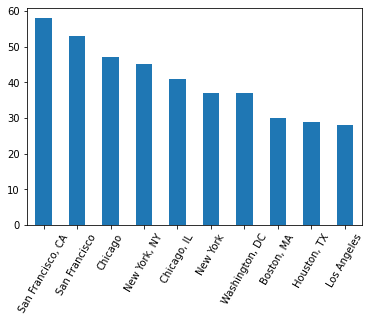

In [ ]:
#Visulize the tweet location
df['tweet_location'].value_counts().head(10).plot(kind='bar', rot=60)

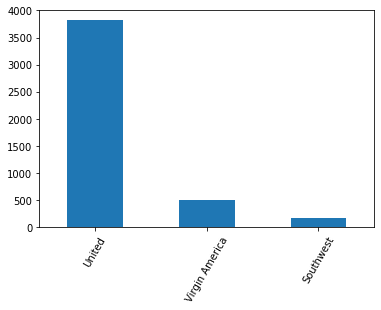

In [ ]:
#Visulize the airlines with the most tweets
df['airline'].value_counts().plot(kind='bar', rot=60)

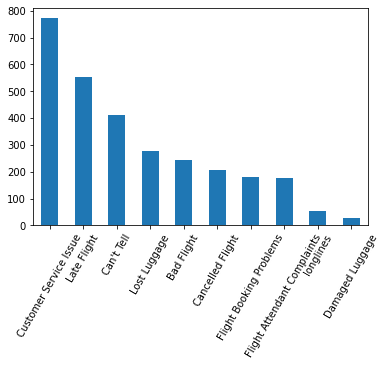

In [ ]:
#Visulize the negative reasons
df['negativereason'].value_counts().plot(kind='bar', rot=60)
#Majority of the negative tweets were in regards to customer service with 2900 tweets 
#followed by tweets on late flights with 1700tweets

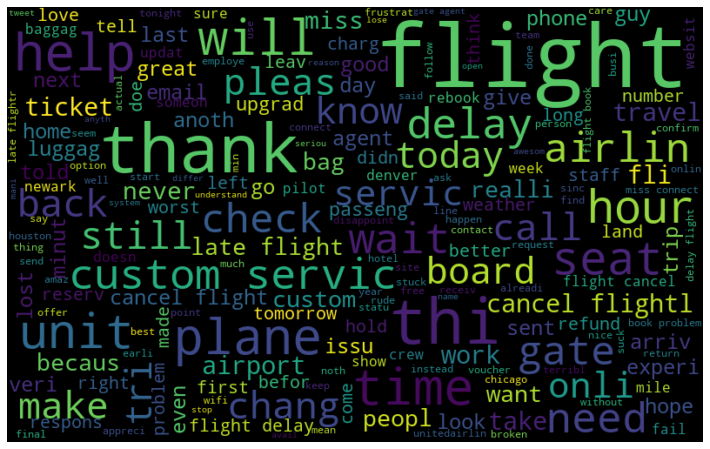

In [ ]:
# visulize frequent words
all_words= " ".join(sentence for sentence in df.clean_tweet)

from wordcloud import WordCloud
wordcloud=WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

#Plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# #label encoding
# from sklearn.preprocessing import LabelEncoder
# le=LabelEncoder()
# df['sentiment']=le.fit_transform(df['sentiment'])
# df.head()

# Words

**Positive Words**

In [ ]:
df.sentiment.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

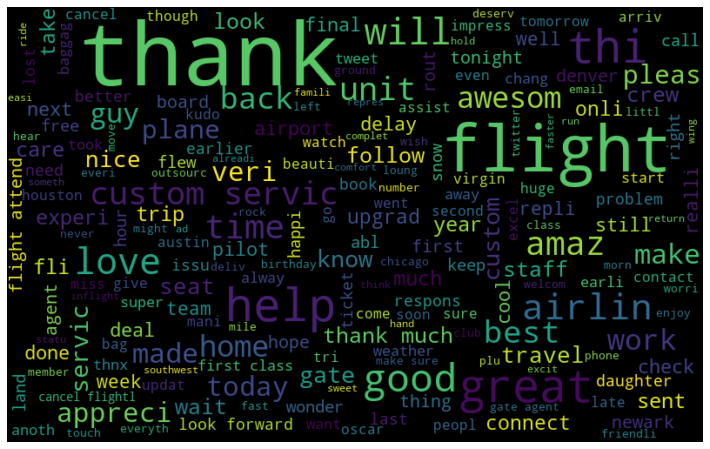

In [ ]:
#Frequent words visulization for positive words
#0=negative, 1=neutral, 2=postive
# visulize frequent words
all_words= " ".join(sentence for sentence in df['clean_tweet'][df['sentiment']=='positive'])

wordcloud=WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

#Plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Negative Words**

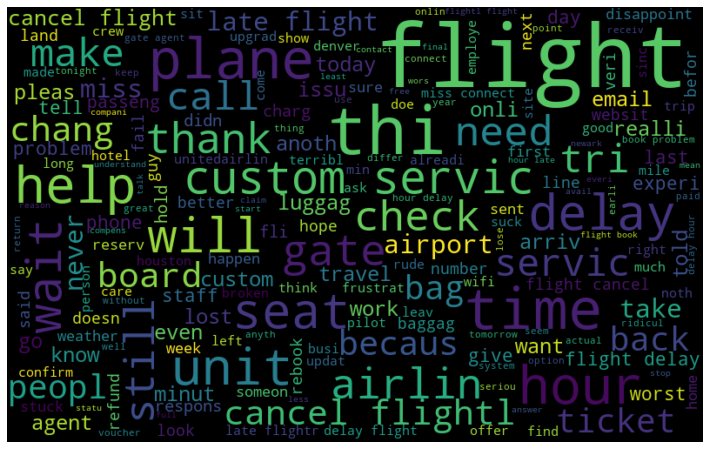

In [ ]:
#Frequent words visulization for negative words
# visulize frequent words
all_words= " ".join(sentence for sentence in df['clean_tweet'][df['sentiment']=='negative'])

wordcloud=WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

#Plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Neutral Words**

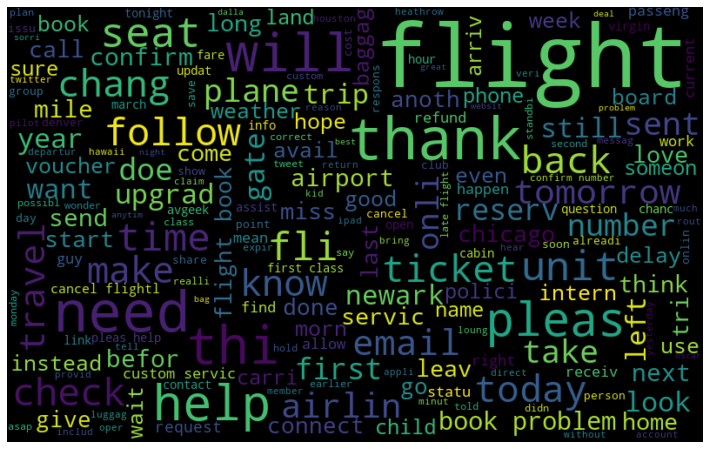

In [ ]:
#Frequent words visulization for neutral words
# visulize frequent words
all_words= " ".join(sentence for sentence in df['clean_tweet'][df['sentiment']=='neutral'])

wordcloud=WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

#Plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

 **Hashtags**

In [ ]:
# Extracting the hashtag
def hashtag_extract(tweets):
  hashtags=[]
  #loop words in tweet
  for tweet in tweets:
    ht=re.findall(r"#(\w+)", tweet)
    hashtags.append(ht)
  return hashtags

In [ ]:
#Extracts from all the emotions
#Extract for positive
ht_positive= hashtag_extract(df['clean_tweet'][df['sentiment']=='positive'])
#Extract for negative
ht_negative= hashtag_extract(df['clean_tweet'][df['sentiment']=='negative'])

In [ ]:
#Combine into a single list
ht_positive = sum(ht_positive, [])
ht_negative = sum(ht_negative, [])
print(ht_positive[:5])
print(ht_negative[:5])

['fabul', 'seduct', 'stress', 'moodlitmonday', 'elevategold']
['fail', 'noair', 'worstflightev', 'roast', 'sfotobo']


**Visulize postive hashtags**

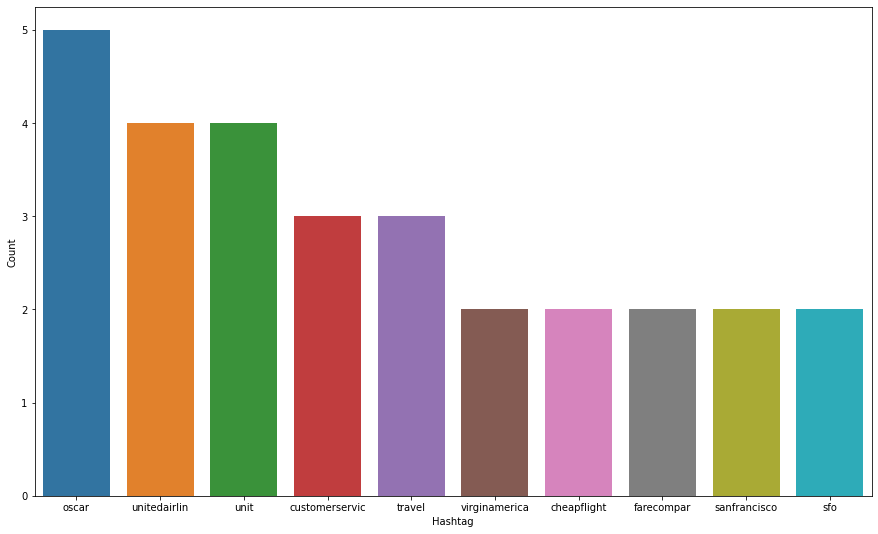

In [ ]:
freq=nltk.FreqDist(ht_positive)
d=pd.DataFrame({"Hashtag": list(freq.keys()),
                "Count": list(freq.values())})
#Select top ten hashtags
d=d.nlargest(columns="Count", n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

**Visulize Negative Hashtags**

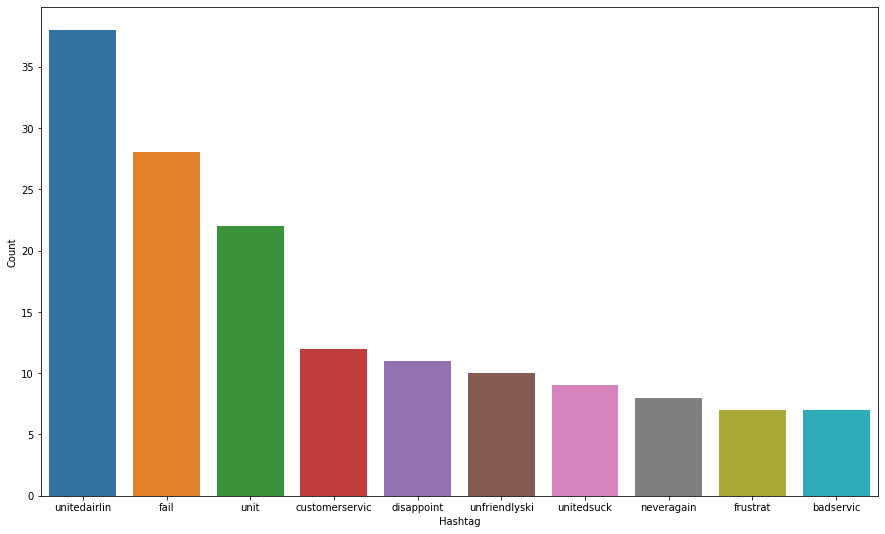

In [ ]:
freq=nltk.FreqDist(ht_negative)
d=pd.DataFrame({"Hashtag": list(freq.keys()),
                "Count": list(freq.values())})
#Select top ten hashtags
d=d.nlargest(columns="Count", n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

# Modelling

## Feature Extraction


In [ ]:
#feature Extraction
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, 
                                min_df=2, 
                                max_features=1000, 
                                stop_words='english')
bow=bow_vectorizer.fit_transform(df['clean_tweet'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test=train_test_split(bow,df['sentiment'],random_state=42,test_size=0.2)

## Model Training

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
#fit model and train
model=MLPClassifier(hidden_layer_sizes = (13, 13,13), max_iter = 500)
model.fit(X_train,y_train)

#prediction
pred=model.predict(X_test)
# Evaluating the performance of ur model
print (confusion_matrix(y_test,pred))

print('-----------------------------------------------')

print(classification_report(y_test,pred))

[[475  56  34]
 [ 79  92  20]
 [ 42  27  74]]
-----------------------------------------------
              precision    recall  f1-score   support

    negative       0.80      0.84      0.82       565
     neutral       0.53      0.48      0.50       191
    positive       0.58      0.52      0.55       143

    accuracy                           0.71       899
   macro avg       0.63      0.61      0.62       899
weighted avg       0.70      0.71      0.71       899



In [ ]:
#selecting the required columns
tweet_df = df[['clean_tweet','sentiment']]
print(tweet_df.shape)
tweet_df.head(5)

(4493, 2)


,clean_tweet,sentiment
0,what said,neutral
1,plu ad commerci experi tacki,positive
2,didn today must mean need take anoth trip,neutral
3,realli aggress blast obnoxi entertain your gue...,negative
4,realli thing about,negative


In [ ]:
#Get the value counts of the sentiments
df['sentiment'].value_counts()

negative    2906
neutral      914
positive     673
Name: sentiment, dtype: int64

In [ ]:
#we are only interested in positive and negative sentiments
tweet_df = tweet_df[tweet_df['sentiment'] != 'neutral']
print(tweet_df['sentiment'].value_counts())
tweet_df.head()

negative    2906
positive     673
Name: sentiment, dtype: int64


,clean_tweet,sentiment
1,plu ad commerci experi tacki,positive
3,realli aggress blast obnoxi entertain your gue...,negative
4,realli thing about,negative
5,serious would flight seat that didn have thi p...,negative
6,nearli everi time thi worm away,positive


In [ ]:
#factorize the sentiment label
sentiment_label = tweet_df.sentiment.factorize()
sentiment_label

(array([0, 1, 0, ..., 2, 2, 0]),
 Index(['neutral', 'positive', 'negative'], dtype='object'))

In [ ]:
#Tokinize the tweets
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tweet = tweet_df.clean_tweet.values
tokenizer = Tokenizer(num_words=5000)
tweets=tokenizer.fit_on_texts(tweet)
#getting the vocab_size
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)
print(tokenizer.word_index)

{'flight': 1, 'your': 2, 'that': 3, 'have': 4, 'thank': 5, 'with': 6, 'thi': 7, 'from': 8, 'delay': 9, 'http': 10, 'time': 11, 'servic': 12, 'custom': 13, 'just': 14, 'hour': 15, 'help': 16, 'will': 17, 'unit': 18, 'plane': 19, 'they': 20, 'what': 21, 'cancel': 22, 'wait': 23, 'seat': 24, 'been': 25, 'airlin': 26, 'gate': 27, 'there': 28, 'need': 29, 'check': 30, 'when': 31, 'still': 32, 'would': 33, 'book': 34, 'about': 35, 'miss': 36, 'make': 37, 'pleas': 38, 'back': 39, 'after': 40, 'like': 41, 'again': 42, 'late': 43, 'tri': 44, 'call': 45, 'board': 46, 'chang': 47, 'ticket': 48, 'agent': 49, 'connect': 50, 'problem': 51, 'today': 52, 'take': 53, 'know': 54, 'airport': 55, 'onli': 56, 'last': 57, 'flightl': 58, 'never': 59, 'travel': 60, 'first': 61, 'more': 62, 'work': 63, 'over': 64, 'becaus': 65, 'issu': 66, 'fli': 67, 'email': 68, 'were': 69, 'bag': 70, 'then': 71, 'lost': 72, 'should': 73, 'realli': 74, 'even': 75, 'want': 76, 'peopl': 77, 'minut': 78, 'luggag': 79, 'good': 80

### Wandb

In [ ]:
#Install and login
!pip install wandb
import wandb
wandb.login()

     |████████████████████████████████| 1.6 MB 5.6 MB/s 
     |████████████████████████████████| 170 kB 67.7 MB/s 
     |████████████████████████████████| 97 kB 5.7 MB/s 
     |████████████████████████████████| 133 kB 64.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=bc0637315a32b46d842a7ef46563622e4eeacf9aee76fbe8507a1ec9fab73fc9
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=b674613493e2d197a59170bd41134ebca2ca4a4fa0117de89e1d0b35577c81f5
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="Visulize-Airlines Tweet Analysis")

wandb: Currently logged in as: jack-analyst (use `wandb login --relogin` to force relogin)


In [ ]:
from wandb.keras import WandbCallback

### Base Model

In [ ]:
#config
config = wandb.config
#Create a tensorflow model
embedding_vector_length = 32
base_model = Sequential() 
base_model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
base_model.add(Dense(1, activation='sigmoid')) 
base_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(base_model.summary()) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           143488    
_________________________________________________________________
dense (Dense)                (None, 200, 1)            33        
Total params: 143,521
Trainable params: 143,521
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#fit the model
history = base_model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32,callbacks=[WandbCallback()] )

Epoch 1/5
113/113 [==============================] - 2s 7ms/step - loss: 0.1980 - accuracy: 0.1507 - val_loss: -0.3414 - val_accuracy: 0.1469
Epoch 2/5
113/113 [==============================] - 1s 5ms/step - loss: -0.9902 - accuracy: 0.1508 - val_loss: -1.5872 - val_accuracy: 0.1470
Epoch 3/5
113/113 [==============================] - 1s 5ms/step - loss: -2.4268 - accuracy: 0.1513 - val_loss: -3.2295 - val_accuracy: 0.1470
Epoch 4/5
113/113 [==============================] - 1s 5ms/step - loss: -4.4970 - accuracy: 0.1514 - val_loss: -5.5900 - val_accuracy: 0.1470
Epoch 5/5
113/113 [==============================] - 1s 5ms/step - loss: -6.4798 - accuracy: 0.1514 - val_loss: -6.4050 - val_accuracy: 0.1470


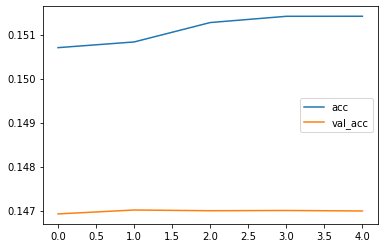

In [ ]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

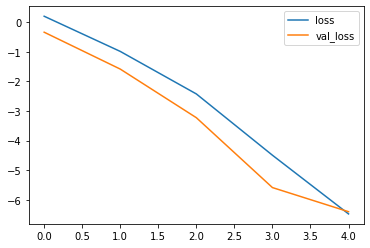

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Hyperparametric Tuning

In [ ]:
wandb.init(project="Visulize-Airlines Tweet Analysis Tuned")

epoch,4
loss,-6.47975
accuracy,0.15142
val_loss,-6.40496
val_accuracy,0.14699
_runtime,26
_timestamp,1629051122
_step,4
best_val_loss,-6.40496
best_epoch,4


epoch,▁▃▅▆█
loss,█▇▅▃▁
accuracy,▁▂▇██
val_loss,█▇▅▂▁
val_accuracy,▁█▇▇▆
_runtime,▁▅▅██
_timestamp,▁▅▅██
_step,▁▃▅▆█


In [ ]:
#config
config = wandb.config

#Create a tensorflow model
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           143488    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 160,139
Trainable params: 160,139
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#fit the model
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32,callbacks=[WandbCallback()])

Epoch 1/5
113/113 [==============================] - 30s 235ms/step - loss: -3.2171 - accuracy: 0.1519 - val_loss: -5.5527 - val_accuracy: 0.1468
Epoch 2/5
113/113 [==============================] - 29s 258ms/step - loss: -7.1553 - accuracy: 0.1505 - val_loss: -8.3393 - val_accuracy: 0.1468
Epoch 3/5
113/113 [==============================] - 27s 243ms/step - loss: -10.0267 - accuracy: 0.1505 - val_loss: -10.9789 - val_accuracy: 0.1468
Epoch 4/5
113/113 [==============================] - 26s 233ms/step - loss: -12.6417 - accuracy: 0.1505 - val_loss: -13.4431 - val_accuracy: 0.1468
Epoch 5/5
113/113 [==============================] - 26s 232ms/step - loss: -15.2068 - accuracy: 0.1505 - val_loss: -15.8837 - val_accuracy: 0.1468


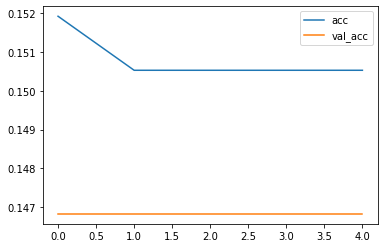

In [ ]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

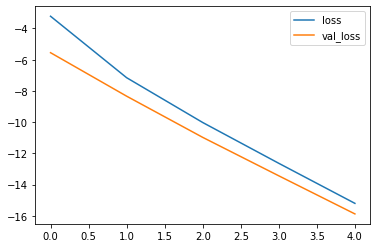

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

In [ ]:
#o= negative and 2= positive
text = input("Enter any sentiment about a flight:")
predict_sentiment(text)

Enter any sentiment about a flight:i love the flight
Predicted label:  positive
